## Какой тариф выгоднее?

belbor1@gmail.com

In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime as dt
import math
from scipy.stats import ttest_ind

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
# чтобы не делать deepcopy для устранения требования SettingWithCopyError, ячейки [45], [46]
pd.options.mode.chained_assignment = None

# Подготовка данных


## Проверка данных

#### Особенности данных (проблемы и ошибки):

1. Данные по звонкам, сообщениям, интернету имеют свои индексы (id) и даты (...date), которые между собой не совпадают. Также таблицы имеют различную длину и различающийся набор пользователей (492 (calls), 497 (internet), 426 (messages)). Это не позволяет агрегировать данные в один датафрейм. Работать необходимо с таблицами по-отдельности.

2. Тип значений даты. Необходимо посчитать статистику по месяцам. Для этого надо из имеющихся данных для каждой строки вытащить значение месяца. Вариант решения: перевести дату из типа object в datetime и методом .month извлечь значение месяца.

3. Нулевые значения в столбцах duration (calls) и mb_used (internet). Они повлияют на расчет оценок. Строки со значением 0.0 в этих столбцах надо исключить.

4. В тарифах стоимость сверх ежемесячного пакета указана за гигабайт. Для расчетов удобнее будет перевести в мегабайты.

5. Некоторые пользователи закончили использовать тариф в 2018 г. (churn_date) Для снижения погрешности анализа, исключим этих пользователей из выборки.

6. Продолжительность разговора представлена в десятичных  дробях. Согласно условиям её надо округлить до целого числа в большую сторону.

Загрузим таблицы и для каждой посмотрим содержание.
Также проверим наличие пропусков, типы переменных в столбцах, наличие нулевых значений.

### Тарифы

In [5]:
tariffs = pd.read_csv('datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Звонки

In [6]:
calls = pd.read_csv('datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [8]:
# количество пользователей
calls['user_id'].nunique()

492

In [9]:
# количество звонков
calls['id'].nunique()

202607

In [10]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [11]:
# Проверим столбцы ['call_date'] и ['id'] на аномальные значения
calls['call_date'].min()

'2018-01-01'

In [12]:
calls['call_date'].max()

'2018-12-31'

In [13]:
calls['id'].min()

'1000_0'

In [14]:
calls['id'].max()

'1499_99'

### Сообщения

In [15]:
messages = pd.read_csv('datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
# Проверим столбцы ['message_date'] и ['id'] на аномальные значения
messages['message_date'].min()

'2018-01-02'

In [18]:
messages['message_date'].max()

'2018-12-31'

In [19]:
messages['id'].min()

'1000_0'

In [20]:
messages['id'].max()

'1499_99'

In [21]:
# количество пользователей в выборке сообщений
messages['user_id'].nunique()

426

### Интернет

In [22]:
internet = pd.read_csv('datasets/internet.csv')
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [23]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [24]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [25]:
# Проверим столбцы ['message_date'] и ['id'] на аномальные значения
internet['session_date'].min()

'2018-01-01'

In [26]:
internet['session_date'].max()

'2018-12-31'

In [27]:
internet['id'].min()

'1000_0'

In [28]:
internet['id'].max()

'1499_99'

In [29]:
# количество пользователей в выборке интернет
internet['user_id'].nunique()

497

### Пользователи

In [30]:
users = pd.read_csv('datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


## Предобработка данных

In [32]:
# Подсчет выручки

def proceeds_calculate(monhtly_table, included, cost):
    """
    Расчет выручки заданной характеристики тарифа 
    и формирование датафрейма со значениями выручки 
    по месяцам и пользователям.
    
        monhtly_table: dataframe, содеращий столбцы с месячными значениями 
        заданной характеристики по пользователям и столбец с индексом тарифа ['tariff']
        
        included: str, название столбца из таблицы tariffs, в котором указан объем доступного 
        элемента пакета по тарифу
        
        cost: str, название столбца из таблицы tariffs, в котором указана стоимость 
        дополнительных единиц элемента пакета в случае превышения базового объема
        
        
    example: proceeds_calculate(month_dur_fin, 'minutes_included', 'rub_per_minute')
    """
    
    
    list_of_df = []
    
    for tariff in tariff_names.values():

        proceeds = ((monhtly_table[monhtly_table['tariff'] == tariff].iloc[:,0:12] 
         - tariffs.loc[tariffs.index[[tariff]], included][tariff]) 
                          * tariffs.loc[tariffs.index[[tariff]], cost][tariff])

        proceeds = proceeds[proceeds > 0]

        list_of_df.append(proceeds)

    return (pd.concat(list_of_df).sort_index().merge(
        user_use, how='inner', left_index=True, right_index=True)
           )

### Тарифы

1. Пересчитаем цены за 1 гб в цену за 1 мб.
2. Соответсвенно измененим название столбца.

In [33]:
tariffs['rub_per_gb'] = tariffs['rub_per_gb'].apply(lambda x: x / 1024)

In [34]:
tariffs.rename(columns={'rub_per_gb' : 'rub_per_mb'}, inplace=True)
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,0.195312,3,3,smart
1,1000,30720,3000,1950,0.146484,1,1,ultra


### Пользователи

1. Ставим в индекс датафрейма user_id для удобства
2. Исключаем пользователей, который прекратили использовать тариф в 2018 г.
3. Формируем датафрем для объединения с другими таблицами

In [35]:
users = users.set_index('user_id')

In [36]:
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [37]:
# Исключаем пользователей, которые прекратили пользоваться тарифом
end_of_use = users.churn_date[users.churn_date.notna()]
users = users.drop(index=end_of_use.index, axis=0)

In [38]:
# Создаем датафрейм с id, городом и тарифом пользователя
tariff_names = {'smart': 0, 'ultra': 1}

user_use = users.loc[:, ['city', 'tariff']]
user_use['tariff'] = user_use['tariff'].apply(lambda x: tariff_names.get(str(x)))
user_use

,city,tariff
user_id,,
1000,Краснодар,1
1001,Москва,0
1002,Стерлитамак,0
1003,Москва,1
1004,Новокузнецк,1
...,...,...
1494,Омск,0
1495,Иркутск,1
1496,Вологда,0


### Звонки

1. Изменим тип данных даты на datetime.
2. Оставим в датафрейме строки с продолжительностью звонков > 0.
4. Округлим продолжительность в сторону большего целого.
5. Вынесем значение месяца в отдельный столбец.
6. Выполним расчеты продолжительности и количества звонков, выручки по каждому пользователю и месяцу.

In [39]:
# Меняем тип данных для значений даты 
calls['call_date'] = calls['call_date'].astype('datetime64[D]')
calls.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

In [40]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [41]:
# Количество строк с нулевым значением продолжительности разговора
len(calls[calls['duration'] == 0])

39613

In [42]:
# Фильтруем по объему использованного интернета больше 0.0
calls = calls[calls['duration'] > 0]
calls.describe()

,duration,user_id
count,162994.000000,162994.000000
mean,8.397794,1254.149877
std,5.353022,144.751050
min,0.010000,1000.000000
25%,4.170000,1126.000000
50%,7.740000,1261.000000
75%,11.850000,1379.000000
max,38.000000,1499.000000


In [43]:
# Проверка на наличие нулевых значений
len(calls[calls['duration'] == 0])

0

In [44]:
# Округляем продолжительность вызовов в большую сторону
duratin_list = calls['duration'].to_list()
duration_int = []
for i in duratin_list:
    
    duration_int.append(math.ceil(i))
    
duration = np.array(duration_int)
duration

array([ 3, 14,  6, ..., 11,  5, 20])

In [45]:
# Заменим значения продолжительности на округленные 
calls.loc[:,'duration'] = duration

In [46]:
# Создаем отдельный столбец со значением месяца
calls.loc[:,'month'] = calls.loc[:, 'call_date'].dt.month

In [47]:
calls

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


#### Таблица суммарной продолжительности вызовов по месяцам и пользователям

In [48]:
# Рассчитываем продолжтельность вызовов
month_dur = (calls.pivot_table(columns='month', index='user_id', values='duration',
                                   aggfunc=np.sum))
             
# Добавляем сведения о пользователях
month_dur_fin = month_dur.merge(user_use, how='inner', left_index=True, right_index=True)

month_dur_fin

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,Краснодар,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,Москва,0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,Москва,1
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,Новокузнецк,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,501.0,354.0,411.0,418.0,Омск,0
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0,Иркутск,1
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0,Вологда,0


#### Таблица выручки за звонки сверх лимита по месяцам и пользователям

In [49]:
proceeds_calls = proceeds_calculate(month_dur_fin, 'minutes_included', 'rub_per_minute')
proceeds_calls

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Краснодар,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Москва,0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Москва,1
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Новокузнецк,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,Омск,0
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иркутск,1
1496,NaN,282.0,171.0,63.0,NaN,165.0,246.0,81.0,NaN,NaN,486.0,54.0,Вологда,0


#### Количество вызовов по пользователям за каждый месяц

In [50]:
# Рассчитываем количество вызовов
month_calls = calls.pivot_table(columns='month', index='user_id', values='id',
                                   aggfunc='count')
# Добавляем сведения о пользователях
month_calls_fin = month_calls.merge(user_use, how='inner', left_index=True, 
                                    right_index=True)
month_calls_fin

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,17.0,28.0,41.0,42.0,46.0,44.0,37.0,38.0,Краснодар,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,47.0,Москва,0
1002,NaN,NaN,NaN,NaN,NaN,14.0,21.0,37.0,25.0,24.0,25.0,27.0,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,105.0,97.0,95.0,88.0,Москва,1
1004,NaN,NaN,NaN,NaN,7.0,25.0,20.0,18.0,18.0,21.0,15.0,15.0,Новокузнецк,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,57.0,45.0,46.0,54.0,Омск,0
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,95.0,126.0,112.0,120.0,Иркутск,1
1496,6.0,65.0,67.0,52.0,50.0,57.0,63.0,62.0,58.0,56.0,66.0,65.0,Вологда,0


## Интернет

1. Изменим тип данных даты на datetime.
2. Оставим в датафрейме строки с объемом потраченных мегабайт > 0.
3. Вынесем значение месяца в отдельный столбец.
4. Рассчитаем объем израсходованного интеренета по месяцам.
5. Рассчитаем выручку за расход интеренета сверх лимита тарифного плана.

In [51]:
# Фильтруем по объему использованного интернета больше 0.0
internet = internet[internet['mb_used'] > 0]

In [52]:
internet.describe()

,mb_used,user_id
count,129798.000000,129798.000000
mean,426.087210,1253.046318
std,255.596447,143.782672
min,0.030000,1000.000000
25%,227.460000,1132.000000
50%,400.540000,1252.000000
75%,592.947500,1380.000000
max,1724.830000,1499.000000


In [53]:
# Меняем тит данных для значений даты 
internet['session_date'] = internet['session_date'].astype('datetime64[D]')
internet.dtypes

id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

In [54]:
# Создаем отдельный столбец со значением месяца
internet['month'] = internet['session_date'].dt.month

In [55]:
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


#### Объем израсходованного интернета по месяцам

In [56]:
# Рассчитываем объем израсходованного интернета
month_internet = internet.pivot_table(columns='month', index='user_id', values='mb_used', 
                     aggfunc=np.sum)

# Добавляем сведения о пользователях
month_internet_fin = month_internet.merge(user_use, how='inner', left_index=True, right_index=True)

month_internet_fin

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,Краснодар,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,Москва,0
1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,Москва,1
1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,Новокузнецк,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6590.75,16962.51,17767.24,18052.45,17621.21,Омск,0
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76,Иркутск,1
1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15,Вологда,0


#### Выручка за перерасход интеренета по месяцам и пользователям

In [57]:
proceeds_internet = proceeds_calculate(month_internet_fin, 'mb_per_month_included', 'rub_per_mb')
proceeds_internet

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Краснодар,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,599.480469,NaN,Москва,0
1002,NaN,NaN,NaN,NaN,NaN,NaN,433.613281,968.605469,259.976563,NaN,630.328125,537.837891,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Москва,1
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Новокузнецк,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.990234,470.164063,525.869141,441.642578,Омск,0
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.889648,NaN,1203.971191,NaN,Иркутск,1
1496,NaN,2564.388672,1874.804688,1116.146484,1630.810547,932.482422,1758.742188,1595.708984,2260.673828,2504.525391,1895.195313,1050.029297,Вологда,0


## Сообщения

1. Изменим тип данных даты на datetime.
2. Вынесем значение месяца в отдельный столбец.
3. Рассчитаем количество отправленных сообщений пользоавтелями по месяцам.
4. Рассчитаем выручку за использование сообщений сверх лимита тарифного плана. 

In [58]:
# Меняем дит данных для значений даты
messages['message_date'] = messages['message_date'].astype('datetime64[D]')
messages.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [59]:
# Создаем отдельный столбец со значением месяца
messages['month'] = messages['message_date'].dt.month

#### Количество сообщений по месяцам для каждого пользователя

In [60]:
# Рассчитываем количества отправленных сообщений
month_messages = messages.pivot_table(columns='month', index='user_id', 
                                       values='id', aggfunc='count')
# Добавляем данные о пользователях
month_messages_fin = month_messages.merge(user_use, how='inner', left_index=True, right_index=True)
month_messages_fin

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,Краснодар,1
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,Москва,1
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,Новокузнецк,1
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,Набережные Челны,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,78.0,Красноярск,1
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0,Иркутск,1
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0,Вологда,0


#### Выручка за отправку сообщений сверх лимита

In [61]:
proceeds_messages = proceeds_calculate(month_messages_fin, 'messages_included', 'rub_per_message')
proceeds_messages

,1,2,3,4,5,6,7,8,9,10,11,12,city,tariff
user_id,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Краснодар,1
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Стерлитамак,0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Москва,1
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Новокузнецк,1
1005,NaN,NaN,18.0,NaN,NaN,NaN,18.0,42.0,6.0,NaN,3.0,12.0,Набережные Челны,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Красноярск,1
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Иркутск,1
1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Вологда,0


# Анализ данных



## Звонки

In [62]:
# Рассчитаем среднее, дисперсию, среднеквадратичное отклонение для продолжительности звонков
smart_users_calls = (month_dur_fin[month_dur_fin['tariff']==0]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('Для тарифа smart\n\
В среднем пользователи тратят за месяц: %1.f мин\n\
Дисперсия распределения - %1.f мин**2\n\
СКО - %1.f мин' %
    (smart_users_calls.mean(), 
    smart_users_calls.var(ddof=0), 
    smart_users_calls.std(ddof=0))
     )

ultra_users_calls = (month_dur_fin[month_dur_fin['tariff']==1]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('\nДля тарифа ultra\n\
В среднем пользователи тратят за месяц: %1.f мин\n\
Дисперсия распределения - %1.f мин**2\n\
СКО - %1.f мин' %
    (ultra_users_calls.mean(), 
    ultra_users_calls.var(ddof=0), 
    ultra_users_calls.std(ddof=0))
     )

Для тарифа smart
В среднем пользователи тратят за месяц: 428 мин
Дисперсия распределения - 20574 мин**2
СКО - 143 мин

Для тарифа ultra
В среднем пользователи тратят за месяц: 558 мин
Дисперсия распределения - 74360 мин**2
СКО - 273 мин


Таким образом, среднее количество минут, которое тратят пользователи обоих тарифов (smart: 404 мин, ultra: 527 мин), не превышает установленных лимитов. Однако наблюдается значительный разброс этой характеристики для тарифа smart, о чем свидетельствует величина СКО. СКО для пользователей тарифа ultra больше, чем для пользователей тарифа smart. (smart 136 мин, ultra 257 мин). При этом превышение количества выделенных минут в тарифе ultra не наблюдается. Наглядно это проиллюстрировано на графиках типа boxplot.

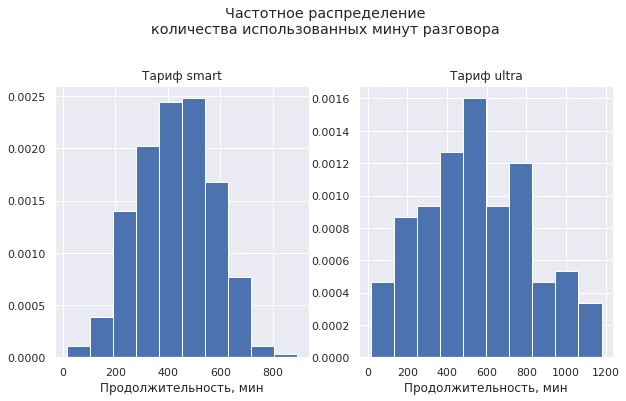

In [63]:
# Построим распределения
fig, axs = plt.subplots(1,2)
sns.set()
axs[0].hist(smart_users_calls, density=True)
axs[1].hist(ultra_users_calls, density=True)


fig.suptitle('Частотное распределение\nколичества использованных минут разговора',
            y=1.1)

axs[0].set_xlabel('Продолжительность, мин')
axs[0].set_title('Тариф smart')

axs[1].set_xlabel('Продолжительность, мин')
axs[1].set_title('Тариф ultra')

fig.set_figheight(5)
fig.set_figwidth(10)

Распределение количества потраченных минут отражено на графиках выше.    
1. Можно отметить, что 28% пользователей тарифа smart расходуют полный или почти полный пакет минут (400-500 мин). 26% пользователей тарифа расходуют более 500 минут. 
2. Пользователи тарифа ultra исопользуют значительно меньше минут, чем выделено в пакете (максимум - 1115 мин). 52 % пользователей тарифа ultra используют более 500 мин в месяц.

In [64]:
# Максимум тарифа ultra
ultra_users_calls.max()

1179.3636363636363

In [65]:
# % пользователей ultra > 500 мин
len(ultra_users_calls[ultra_users_calls > 500]) / len(ultra_users_calls)

0.5813953488372093

In [66]:
# % пользователей smart использующие > 500 мин
len(smart_users_calls[smart_users_calls > 500]) / len(smart_users_calls)

0.3119266055045872

In [67]:
# % пользователей smart использующие от 400 до 500 мин
len(smart_users_calls[(smart_users_calls > 400) & (smart_users_calls < 500)]) / len(smart_users_calls)

0.28134556574923547

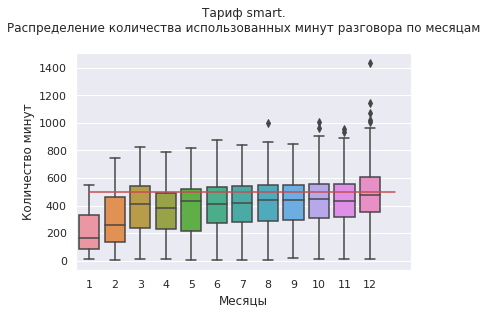

In [68]:
# Построим графики boxplot для более детального рассмотрения распределения
bx = sns.boxplot(data=month_dur_fin[month_dur_fin['tariff'] == 0].iloc[:,0:12])
bx.set_title('Тариф smart.\nРаспределение количества использованных минут разговора по месяцам\n')
bx.set_xlabel('Месяцы')
bx.set_ylabel('Количество минут') 

x1 = [0,12]
y1 = [500, 500]
p1 = plt.plot(x1,y1, c='r')

На графике представлены распределения для каждого месяца 2018 г. Для тарифа smart в семи месяцах из двенвдцати (3,7,8,9,10,11,12) с вероятностью 25% (и менее) наблюдается превышение лимита (500 мин) пользователями по количеству минут разговора. Во второй половине года наблюдаются выбросы со значениями до 1354 мин. Наибольшая продолжительность разговоров наблюдается в декабре, наименьшая в январе. 

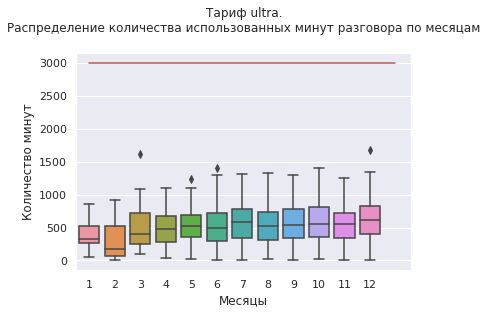

In [69]:
cx = sns.boxplot(data=month_dur_fin[month_dur_fin['tariff'] == 1].iloc[:,0:12])
cx.set_title('Тариф ultra.\nРаспределение количества использованных минут разговора по месяцам\n')
cx.set_xlabel('Месяцы')
cx.set_ylabel('Количество минут') 

x2 = [0,12]
y2 = [3000, 3000]
p2 = plt.plot(x2,y2, c='r')

В тарифе ultra пользователи не превысили лимит по количеству минут разговора(3000 мин). 

In [70]:
# Рассчитаем среднее, дисперсию, среднеквадратичное отклонение для количества звонков
smart_calls = (month_calls_fin[month_calls_fin['tariff']==0]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('Для тарифа smart\n\
В среднем пользователи совершают за месяц %1.f звонков\n\
Дисперсия распределения - %1.f звонков**2\n\
СКО - %1.f звонков' %
    (smart_calls.mean(), 
    smart_calls.var(ddof=0), 
    smart_calls.std(ddof=0))
     )

ultra_calls = (month_calls_fin[month_calls_fin['tariff']==1]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('\nДля тарифа ultra\n\
В среднем пользователи совершают за месяц %1.f звонков\n\
Дисперсия распределения - %1.f звонков**2\n\
СКО - %1.f звонков' %
    (ultra_calls.mean(), 
    ultra_calls.var(ddof=0), 
    ultra_calls.std(ddof=0))
     )

Для тарифа smart
В среднем пользователи совершают за месяц 48 звонков
Дисперсия распределения - 256 звонков**2
СКО - 16 звонков

Для тарифа ultra
В среднем пользователи совершают за месяц 63 звонков
Дисперсия распределения - 949 звонков**2
СКО - 31 звонков


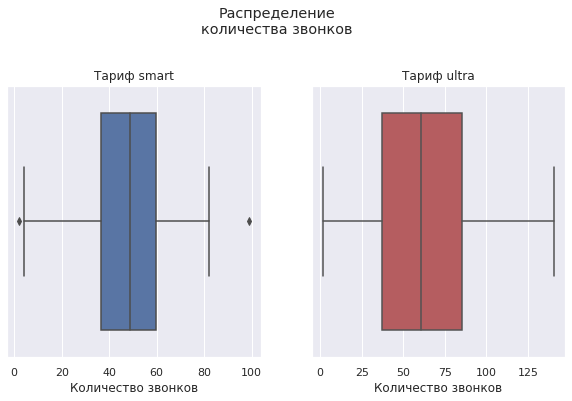

In [71]:
fig, ax =plt.subplots(1,2)
sns.boxplot(ax=ax[0], x=smart_calls)
sns.boxplot(ax=ax[1], x=ultra_calls, color='r')

fig.suptitle('Распределение\nколичества звонков',
            y=1.1)

ax[0].set_xlabel('Количество звонков')
ax[0].set_title('Тариф smart')

ax[1].set_xlabel('Количество звонков')
ax[1].set_title('Тариф ultra')

fig.set_figheight(5)
fig.set_figwidth(10)

Пользователи тарифа ultra в среднем совершают большее количество звонков, чем пользователи тарифа smart. На графике выше границы "коробки" определяют интервал, в котором сконцентрированы 50% пользователей каждого тарифа. 

## Сообщения

In [72]:
# Рассчитаем среднее, дисперсию, среднеквадратичное отклонение
smart_users_messages = (month_messages_fin[month_messages_fin['tariff']==0]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('Для тарифа smart\n\
В среднем пользователи тратят за месяц: %1.f сообщений\n\
Дисперсия распределения - %1.f сообщений**2\n\
СКО - %1.f сообщений' %
    (smart_users_messages.mean(), 
    smart_users_messages.var(ddof=0), 
    smart_users_messages.std(ddof=0))
     )

ultra_users_messages = (month_messages_fin[month_messages_fin['tariff']==1]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('\nДля тарифа ultra\n\
В среднем пользователи тратят за месяц: %1.f сообщений\n\
Дисперсия распределения - %1.f сообщений**2\n\
СКО - %1.f сообщений' %
    (ultra_users_messages.mean(), 
    ultra_users_messages.var(ddof=0), 
    ultra_users_messages.std(ddof=0))
     )

Для тарифа smart
В среднем пользователи тратят за месяц: 38 сообщений
Дисперсия распределения - 636 сообщений**2
СКО - 25 сообщений

Для тарифа ultra
В среднем пользователи тратят за месяц: 66 сообщений
Дисперсия распределения - 1954 сообщений**2
СКО - 44 сообщений


Пользователи обоих тарифов в среднем не превышаю выделенное количество сообщений (smart: 50 сбщ, ultra: 1000 сбщ). Для тарифов наблюдается значительный разброс характеристики, о чем свидетельствует величина СКО (smart 25 сбщ, ultra 44 сбщ). СКО для пользователей тарифа ultra больше, чем для пользователей тарифа smart. При этом превышение количества выделенных сообщений в тарифе ultra не наблюдается. Наглядно это проиллюстрировано на графиках типа boxplot.

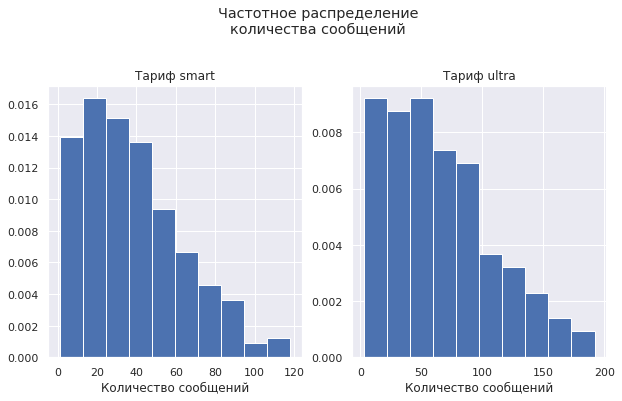

In [73]:
# Построим распределения
fig, axs = plt.subplots(1,2)
sns.set()
axs[0].hist(smart_users_messages, density=True)
axs[1].hist(ultra_users_messages, density=True)


fig.suptitle('Частотное распределение\nколичества сообщений',
            y=1.1)

axs[0].set_xlabel('Количество сообщений')
axs[0].set_title('Тариф smart')

axs[1].set_xlabel('Количество сообщений')
axs[1].set_title('Тариф ultra')

fig.set_figheight(5)
fig.set_figwidth(10)

Распределение количества отправленных сообщений показано на графиках выше.
1. 72% пользователей тарифа smart используют менее 50 собщений в месяц. Максимальное значение, которое в среднем расходует пользователь в месяц составляет 118 сообщений.
2. 80% пользователей тарифа ultra используют менее 100 сообщений при установленном лимите в 1000 сообщений.  Максимальное среднее за месяц количество отправленных сообщений одним пользователем для этого тарифа составляет 192 сообщения

In [74]:
# пользватели smart использующие < 50 сбщ
len(smart_users_messages[smart_users_messages < 50]) / len(smart_users_messages)

0.7163120567375887

In [75]:
# максимальное колтчество использованных сообщений (в среднем) для пользователя smart
smart_users_messages.max()

118.0

In [76]:
# пользватели ultra использующие < 100 сбщ
len(ultra_users_messages[ultra_users_messages < 100]) / len(ultra_users_messages)

0.8

In [77]:
# максимальное колтчество использованных сообщений (в среднем) для пользователя ultra
ultra_users_messages.max()

192.0

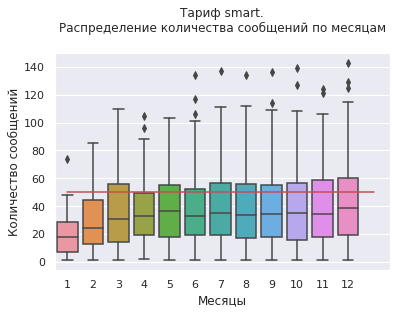

In [78]:
# Построим графики boxplot для более детального рассмотрения распределения
ex = sns.boxplot(data=month_messages_fin[month_messages_fin['tariff'] == 0].iloc[:,0:12])
ex.set_title('Тариф smart.\nРаспределение количества сообщений по месяцам\n')
ex.set_xlabel('Месяцы')
ex.set_ylabel('Количество сообщений') 

x3 = [0,12]
y3 = [50, 50]
p3 = plt.plot(x3,y3, c='r')

На графике представлены распределения для каждого месяца 2018 г. При том, что медиана не превышает отметки в 40 сообщений видно, что пользователи тарифа smart в девяти месяцах (3,5,6,7,8,9,10,11,12) с вероятнстью 25% (и менее) превышают установленный лимит в 50 сообщений. В течение всего года (кроме 2 и 3 месяцев) наблюдаются выбросы со значением до 143 сообщений.

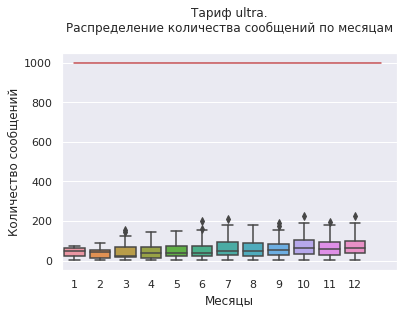

In [79]:
fx = sns.boxplot(data=month_messages_fin[month_messages_fin['tariff'] == 1].iloc[:,0:12])
fx.set_title('Тариф ultra.\nРаспределение количества сообщений по месяцам\n')
fx.set_xlabel('Месяцы')
fx.set_ylabel('Количество сообщений') 

x4 = [0,12]
y4 = [1000, 1000]
p4 = plt.plot(x4,y4, c='r')

В тарифе ultra пользователи не превысили лимит по количеству сообщений (1000 сбщ).

## Интернет

In [80]:
# Рассчитаем среднее, дисперсию, среднеквадратичное отклонение
smart_users_internet = (month_internet_fin[month_internet_fin['tariff']==0]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('Для тарифа smart\n\
В среднем пользователи тратят за месяц: %1.f мб\n\
Дисперсия распределения - %1.f мб**2\n\
СКО - %1.f мб' %
    (smart_users_internet.mean(), 
    smart_users_internet.var(ddof=0), 
    smart_users_internet.std(ddof=0))
     )

ultra_users_internet = (month_internet_fin[month_internet_fin['tariff']==1]
                     .iloc[:,0:12].mean(axis=1)
                    )

print('\nДля тарифа ultra\n\
В среднем пользователи тратят за месяц: %1.f мб\n\
Дисперсия распределения - %1.f мб**2\n\
СКО - %1.f мб' %
    (ultra_users_internet.mean(), 
    ultra_users_internet.var(ddof=0), 
    ultra_users_internet.std(ddof=0))
     )

Для тарифа smart
В среднем пользователи тратят за месяц: 16420 мб
Дисперсия распределения - 12227000 мб**2
СКО - 3497 мб

Для тарифа ultra
В среднем пользователи тратят за месяц: 20104 мб
Дисперсия распределения - 66138000 мб**2
СКО - 8133 мб


Пользователи тарифа smart в среднем используют больше объема интернет-трафика, чем предоставляется в рамках тарифа (15 гб). Пользователи тарифа ultra в среднем не превышают установленный лимит (30 гб). СКО для пользователей тарифа ultra больше, чем для пользователей тарифа smart.
Именно по использованию интернета в тарифе ultra наблюдается превышение лимита. И это единственная из рассмотренных характеристик, которая вносит вклад в выручку от пользователей тарифа ultra.

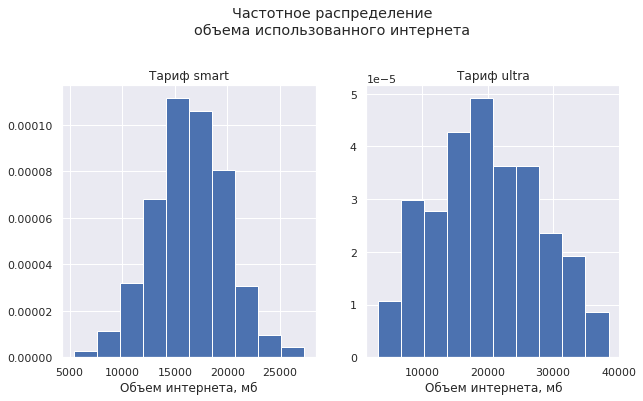

In [81]:
# Построим распределения
fig, axs = plt.subplots(1,2)

axs[0].hist(smart_users_internet, density=True)
axs[1].hist(ultra_users_internet, density=True)


fig.suptitle('Частотное распределение\nобъема использованного интернета',
            y=1.1)

axs[0].set_xlabel('Объем интернета, мб')
axs[0].set_title('Тариф smart')

axs[1].set_xlabel('Объем интернета, мб')
axs[1].set_title('Тариф ultra')

fig.set_figheight(5)
fig.set_figwidth(10)

Распределение количества использованного интернет-трафика показано на графиках выше.
1. 36% пользователей тарифа smart используют интеренет в объеме меньше установленного лимита (15 гб). Максимальное количество использованного интерена пользователем в среднем за месяц составляет 27 гб.
2. 87% пользователей тарифа ultra используют интеренет в объеме меньше установленного лимита (30 гб). Максимальное количество использованного интерена пользователем в среднем за месяц составляет 37 гб.

In [82]:
# пользватели smart использующие < 15 гб
len(smart_users_internet[smart_users_internet < 15*1024]) / len(smart_users_internet)

0.3628048780487805

In [83]:
# максимальной объем использованного интернета (в среднем) для пользователя smart
smart_users_internet.max() / 1024

26.647421875

In [84]:
# пользватели ultra использующие < 30 гб
len(ultra_users_internet[ultra_users_internet < 30*1024]) / len(ultra_users_internet)

0.8796992481203008

In [85]:
# максимальной объем использованного интернета (в среднем) для пользователя ultra
ultra_users_internet.max() / 1024

37.56208007812501

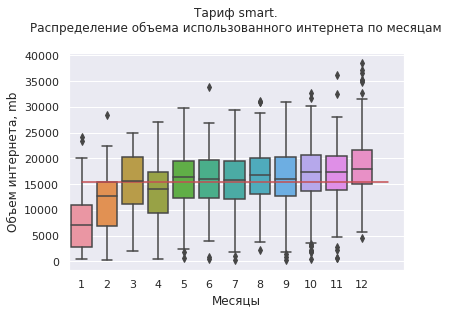

In [86]:
# Построим графики boxplot для более детального рассмотрения распределения
ex = sns.boxplot(data=month_internet_fin[month_internet_fin['tariff'] == 0].iloc[:,0:12])
ex.set_title('Тариф smart.\nРаспределение объема использованного интернета по месяцам\n')
ex.set_xlabel('Месяцы')
ex.set_ylabel('Объем интернета, mb') 

x5 = [0,12]
y5 = [15*1024, 15*1024]
p5 = plt.plot(x5,y5, c='r')

На графике представлены распределения для каждого месяца 2018 г. 
Видно, что медиана распределения в девяти месяцах (3,5,6,7,8,9,10,11,12) превышает установленный лимит. Для семи месяцев (1,2,6,8,10,11,12) наблюдаются выбросы со значениями до 37 гб. 

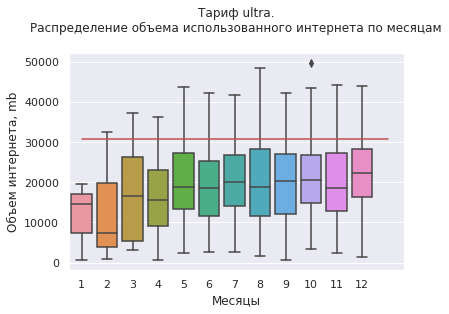

In [87]:
fx = sns.boxplot(data=month_internet_fin[month_internet_fin['tariff'] == 1].iloc[:,0:12])
fx.set_title('Тариф ultra.\nРаспределение объема использованного интернета по месяцам\n')
fx.set_xlabel('Месяцы')
fx.set_ylabel('Объем интернета, mb') 

x6 = [0,12]
y6 = [30*1024, 30*1024]
p6 = plt.plot(x6,y6, c='r')

Для тарифа ultra медиана величины не превышает установленного лимита (30 гб). Верхняя граница размаха распредления для всех месяцев, кроме января, находится выше лимитирующего значения. Это свидетельствует о том, что в каждом из указанных месяцев есть пользователи, которые превышают установленный лимит. 

Таким образом, по тарифу smart превышают лимит: 
* 26% пользователей по звонкам;
* 28% пользователей по сообщениям;
* 64% пользователей по интернету. 

По тарифу ultra превышают лимит: 
* 13% пользователей по интернету. 
По другим характеристикам - не превышают.

# Анализ выручки и проверка гипотез

In [88]:
# Посмотрим сколько составила выручка в 2018 г.
print('Суммарная выручка за звонки в 2018г. составила:\n\
по тарифу smart - %1.f руб.\n\
по тарифу ultra - %1.f руб.'
    % (proceeds_calls[proceeds_calls['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum(), 
      proceeds_calls[proceeds_calls['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum())
)

print('\nСуммарная выручка за сообщения в 2018г. составила:\n\
по тарифу smart - %1.f руб.\n\
по тарифу ultra - %1.f руб.'
    % (proceeds_messages[proceeds_messages['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum(), 
      proceeds_messages[proceeds_messages['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum())
)

print('\nСуммарная выручка за интернет в 2018г. составила:\n\
по тарифу smart - %1.f руб.\n\
по тарифу ultra - %1.f руб.'
    % (proceeds_internet[proceeds_internet['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum(), 
      proceeds_internet[proceeds_internet['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum())
)

print('\nСуммарная выручка в 2018 г. от пользователей тарифа smart составила %1.f руб' % (
    proceeds_calls[proceeds_calls['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum() 
    + proceeds_messages[proceeds_messages['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum()
    + proceeds_internet[proceeds_internet['tariff'] == 0].iloc[:,0:12].sum(axis=1).sum()
)
     )

print('\nСуммарная выручка в 2018 г. от пользователей тарифа ultra составила %1.f руб' % (
    proceeds_calls[proceeds_calls['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum() 
    + proceeds_messages[proceeds_messages['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum()
    + proceeds_internet[proceeds_internet['tariff'] == 1].iloc[:,0:12].sum(axis=1).sum()
)
     )

Суммарная выручка за звонки в 2018г. составила:
по тарифу smart - 275670 руб.
по тарифу ultra - 0 руб.

Суммарная выручка за сообщения в 2018г. составила:
по тарифу smart - 37749 руб.
по тарифу ultra - 0 руб.

Суммарная выручка за интернет в 2018г. составила:
по тарифу smart - 1147334 руб.
по тарифу ultra - 96942 руб.

Суммарная выручка в 2018 г. от пользователей тарифа smart составила 1460753 руб

Суммарная выручка в 2018 г. от пользователей тарифа ultra составила 96942 руб


Отметим, что основной вклад в выручку для обоих тарифов вносит расход сверх лимита интернета

### Рассчитаем среднее значение месячной выручки по каждому пользователю для обоих тарифов

Количество пользователей в выборке smart: 318
Количество пользователей в выборке ultra: 40

Среднее значение выручки с пользователя по тарифу smart: 987 руб.
Среднее значение выручки с пользователя по тарифу ultra: 756 руб.



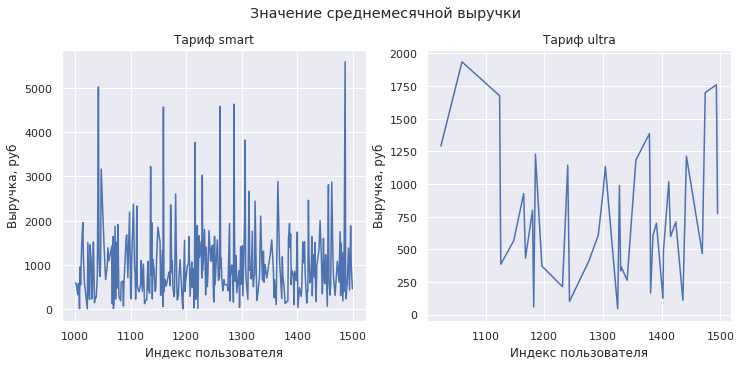

In [89]:
# Значения выручки для каждой категории по месяцам и пользователям
smart1 = proceeds_calls[proceeds_calls['tariff'] == 0].iloc[:,0:12] 
smart2 = proceeds_messages[proceeds_messages['tariff'] == 0].iloc[:,0:12]
smart3 = proceeds_internet[proceeds_internet['tariff'] == 0].iloc[:,0:12]

ultra1 = proceeds_calls[proceeds_calls['tariff'] == 1].iloc[:,0:12] 
ultra2 = proceeds_messages[proceeds_messages['tariff'] == 1].iloc[:,0:12]
ultra3 = proceeds_internet[proceeds_internet['tariff'] == 1].iloc[:,0:12]

# Cуммируем выручку по категориям звонки, сообщения, интернет по месяцам
smart_proceeds_month = pd.concat([smart1, smart2, smart3], axis=0).groupby('user_id').sum()
smart_proceeds_month.replace(0, np.nan, inplace=True)

ultra_proceeds_month = pd.concat([ultra1, ultra2, ultra3], axis=0).groupby('user_id').sum()
ultra_proceeds_month.replace(0, np.nan, inplace=True)

# Считаем среднемесячное значение
smart_proceeds_mean = smart_proceeds_month.mean(axis=1).dropna()
ultra_proceeds_mean = ultra_proceeds_month.mean(axis=1).dropna()

# Визуализируем
fig, axs = plt.subplots(1,2)

fig.suptitle('Значение среднемесячной выручки',
            y=1.0)

axs[0].plot(smart_proceeds_mean)
axs[1].plot(ultra_proceeds_mean)

axs[1].set_title('Тариф ultra')
axs[1].set_xlabel('Индекс пользователя')
axs[1].set_ylabel('Выручка, руб')

axs[0].set_title('Тариф smart')
axs[0].set_xlabel('Индекс пользователя')
axs[0].set_ylabel('Выручка, руб')

fig.set_figheight(5)
fig.set_figwidth(12)

print('Количество пользователей в выборке smart: {}'.format(len(smart_proceeds_mean)))
print ('Количество пользователей в выборке ultra: {}\n'.format(len(ultra_proceeds_mean)))

print('Среднее значение выручки с пользователя по тарифу smart: %1.f руб.\n\
Среднее значение выручки с пользователя по тарифу ultra: %1.f руб.\n' % (
    smart_proceeds_mean.mean(), 
    ultra_proceeds_mean.mean())
     )

#### Проверим равенство математических ожиданий средней выручки по двум тарифам.
Необходимо выяснить дейтвительно ли тариф smart приносит больший доход, чем тариф ultra или же это стастические колебания.

Используем для проверки [t-критерий](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).
    
    scipy.stats.ttest_ind()
    
Пусть значения выборок независимы и подчиняются нормальному распределению. Эта вариация критерия использована, т.к. она успешно применима для рядов с различающимися средним значением, дисперсией и длиной данных.  

1. H0: Математическое ожидание выручки пользователей за тариф smart РАВНО математическому ожиданию выручки пользователей за тариф ultra.
2. H1: Математическое ожидание выручки пользователей за тариф smart НЕ РАВНО математическому ожиданию выручки пользователей за тариф ultra.

In [90]:
# Провека гипотезы на равенство мат. ожиданий
stat, p = ttest_ind(smart_proceeds_mean, ultra_proceeds_mean, equal_var=False)

alpha = 0.05 # уровень значимости

print('Статистика=%.3f, p-value=%.3f' % (stat, p))

if p > alpha:
    print('\nСтатистически достоверно доказана гипотеза H0 при уровне значимости 5%.\n\
Математическое ожидание выручки пользователей за тариф smart\n\
РАВНО математическому ожиданию выручки пользователей за тариф ultra.')
else:
    print('\nСтатистически достоверно опровергнута гипотеза H0 при уровне значимости 5%.\n\
Математическое ожидание выручки пользователей за тариф smart\n\
НЕ РАВНО математическому ожиданию выручки пользователей за тариф ultra.')

Статистика=2.476, p-value=0.016

Статистически достоверно опровергнута гипотеза H0 при уровне значимости 5%.
Математическое ожидание выручки пользователей за тариф smart
НЕ РАВНО математическому ожиданию выручки пользователей за тариф ultra.


Таким образом, можем заключить что выручка от пользователей тарифа smart превышает выручку 
от пользователей тарифа ultra.

### Рассчитаем среднее значение месячной выручки по каждому пользователю для Москвы и других регионов

Количество пользователей в выборке по Москве: 70
Количество пользователей в выборке по другим регионам: 288

Среднее значение выручки с пользователя из Москвы: 865 руб.
Среднее значение выручки с пользователя из другого региона: 985 руб.



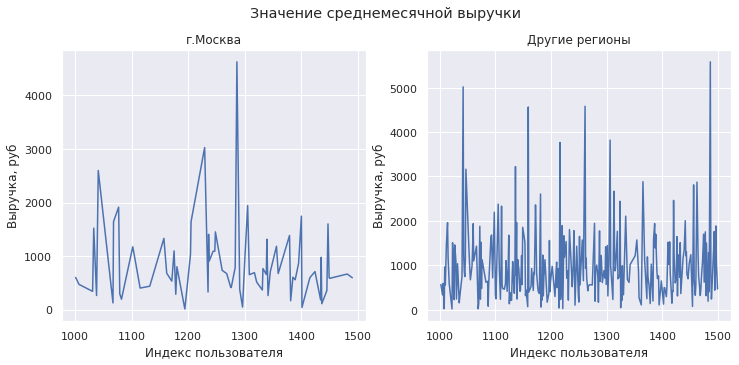

In [91]:
# Значения выручки для каждой категории по месяцам и пользователям
moscow1 = proceeds_calls[proceeds_calls['city'] == 'Москва'].iloc[:,0:12] 
moscow2 = proceeds_messages[proceeds_messages['city'] == 'Москва'].iloc[:,0:12]
moscow3 = proceeds_internet[proceeds_internet['city'] == 'Москва'].iloc[:,0:12]

other1 = proceeds_calls[proceeds_calls['city'] != 'Москва'].iloc[:,0:12] 
other2 = proceeds_messages[proceeds_messages['city'] != 'Москва'].iloc[:,0:12]
other3 = proceeds_internet[proceeds_internet['city'] != 'Москва'].iloc[:,0:12]

# Cуммируем выручку по категориям звонки, сообщения, интернет по месяцам
moscow_proceeds_month = (pd.concat([moscow1, moscow2, moscow3], axis=0)
                        .groupby('user_id').sum())
moscow_proceeds_month.replace(0, np.nan, inplace=True)

cities_proceeds_month = (pd.concat([other1, other2, other3], axis=0)
                        .groupby('user_id').sum())
cities_proceeds_month.replace(0, np.nan, inplace=True)

# Считаем среднемесячное значение
moscow_proceeds_mean = moscow_proceeds_month.mean(axis=1).dropna()
cities_proceeds_mean = cities_proceeds_month.mean(axis=1).dropna()

# Визуализируем
fig, axs = plt.subplots(1,2)

fig.suptitle('Значение среднемесячной выручки',
            y=1.0)

axs[0].plot(moscow_proceeds_mean)
axs[1].plot(cities_proceeds_mean)

axs[1].set_title('Другие регионы')
axs[1].set_xlabel('Индекс пользователя')
axs[1].set_ylabel('Выручка, руб')

axs[0].set_title('г.Москва')
axs[0].set_xlabel('Индекс пользователя')
axs[0].set_ylabel('Выручка, руб')

fig.set_figheight(5)
fig.set_figwidth(12)

print('Количество пользователей в выборке по Москве: {}'.format(len(moscow_proceeds_mean)))
print ('Количество пользователей в выборке по другим регионам: {}\n'.format(len(cities_proceeds_mean)))

print('Среднее значение выручки с пользователя из Москвы: %1.f руб.\n\
Среднее значение выручки с пользователя из другого региона: %1.f руб.\n' % (
    moscow_proceeds_mean.mean(), 
    cities_proceeds_mean.mean())
     )

#### Проверим равенство математических ожиданий средней выручки по Москве и другим городам.
Необходимо выяснить дейтвительно ли пользователи из других регионов приносят больший доход, чем пользователи из Москвы или же это случайные колебания. 

Используем для проверки [t-критерий](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).
    
    scipy.stats.ttest_ind()
    
Пусть значения выборок независимы и подчиняются нормальному распределению. Эта вариация критерия использована, т.к. она успешно применима для рядов с различающимися средним значением, дисперсией и длиной данных.   

1. H0: Математическое ожидание выручки пользователей из Москвы РАВНО математическому ожиданию выручки пользователей из других регионов.
2. H1: Математическое ожидание выручки пользователей из Москвы НЕ РАВНО математическому ожиданию выручки пользователей из других регионов.

In [92]:
# Провека гипотезы на равенство мат. ожиданий
stat, p = ttest_ind(moscow_proceeds_mean, cities_proceeds_mean, equal_var=False)

alpha = 0.05 # уровень значимости

print('Статистика=%.3f, p-value=%.3f' % (stat, p))

if p > alpha:
    print('\nСтатистически достоверно доказана гипотеза H0 при уровне значимости 5%.\n\
Математическое ожидание выручки пользователей из Москвы\n\
РАВНО математическому ожиданию выручки пользователей из других регионов')
else:
    print('\nСтатистически достоверно опровергнута гипотеза H0 приуровне значимости 5%.\n\
Математическое ожидание выручки пользователей из Москвы\n\
НЕ РАВНО математическому ожиданию выручки пользователей из других регионов.')

Статистика=-1.182, p-value=0.240

Статистически достоверно доказана гипотеза H0 при уровне значимости 5%.
Математическое ожидание выручки пользователей из Москвы
РАВНО математическому ожиданию выручки пользователей из других регионов


Таким образом, можем заключить что выручка от пользователей из других регионов не превышает выручку от пользователей из Москвы.

## Вывод

Результаты статистических тестов показывают, что пользователь тарифа smart в среднем приносит больше денег компании, чем пользователь тарифа ultra, и при этом доход от пользователей в г.Москве не отличается от дохода от пользователей других регионов. 

Следует учесть, что за 2018 г. наибольший в вклад в выручку принесло использование пользователями мобильного интернета сверх лимита (для обоих тарифов). Для тарифа smart наблюдалось превышение лимитов пользователями по всем категориям (звонки, сообщения, интернет). Для тарифа ultra - только по категории мобильного интернета.